# FedProx Implementation (Assignment 4, Task 4.1)

This notebook implements the **FedProx** algorithm as described in Task 4.1 of the assignment. 

**Goal:** Modify the client-side training (FedAvg) to include a proximal term. This term penalizes the local model for moving too far from the global model it received at the start of the round.

The modified loss on the client is:

$$L_{client} = L_{local} + \frac{\mu}{2} ||\theta - \theta_{g}^{t}||^2$$

Where:
* $L_{local}$ is the standard cross-entropy loss on the client's local data batch.
* $\mu$ (mu) is the regularization hyperparameter.
* $\theta$ (theta) represents the current local model parameters being trained.
* $\theta_{g}^{t}$ (theta_g_t) represents the global model parameters received from the server at the beginning of round $t$.

## 1. Imports

Import all necessary libraries from PyTorch, torchvision, NumPy, and Matplotlib.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import random

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Hyperparameters and Device Setup

We define all key hyperparameters here. To test FedProx's effectiveness, we set a high degree of heterogeneity (`alpha=0.1`) and a `mu=0.01` as suggested.

In [2]:
HYPERPARAMS = {
    "num_clients": 5,          # 5-10 clients suggested 
    "num_rounds": 50,          # Total communication rounds
    "local_epochs": 5,           # K=5 local epochs per round
    "batch_size": 32,
    "learning_rate": 0.01,
    "mu": 0.01,                  # FedProx proximal term
    "dirichlet_alpha": 0.1,      # For highly non-IID data (small alpha = high skew)
    "seed": 42
}

# Set random seeds for reproducibility
torch.manual_seed(HYPERPARAMS['seed'])
np.random.seed(HYPERPARAMS['seed'])
random.seed(HYPERPARAMS['seed'])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Model Definition (Simple CNN)

As recommended, we use a small Convolutional Neural Network (CNN) suitable for CIFAR-10.

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Two conv layers as suggested 
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        # A small FC layer
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_check = CNN().to(device)
print(model_check)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 4. Data Loading and Partitioning (Non-IID)

This section contains helper functions to load CIFAR-10 and partition it among clients using a **Dirichlet distribution**, as specified in Task 3. This is necessary to create the non-IID scenario to test FedProx.

In [4]:
def get_cifar10_data():
    """Downloads CIFAR-10 train and test datasets."""
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    return trainset, testset

def dirichlet_partition_data(dataset, num_clients, alpha):
    """
    Partitions data among clients using a Dirichlet distribution (for label skew).
    Based on Task 3 instructions.
    """
    labels = np.array(dataset.targets)
    num_classes = len(np.unique(labels))
    idx_by_class = {i: np.where(labels == i)[0] for i in range(num_classes)}

    # Generate class proportions for each client from Dir(alpha)
    # Each row is a client, each column is a class
    class_proportions = np.random.dirichlet([alpha] * num_clients, num_classes)
    
    client_data_indices = {i: [] for i in range(num_clients)}
    
    # Keep track of how many samples of each class have been assigned
    class_sample_counts = {i: len(idx_by_class[i]) for i in range(num_classes)}
    class_sample_ptr = {i: 0 for i in range(num_classes)}

    for c in range(num_classes):
        class_indices = idx_by_class[c]
        np.random.shuffle(class_indices)
        
        # Calculate how many samples each client gets for this class
        proportions = class_proportions[c]
        num_samples_for_class = class_sample_counts[c]
        client_counts = (proportions * num_samples_for_class).astype(int)
        
        # Adjust counts to sum up to the total number of samples for the class
        # (due to integer rounding)
        diff = num_samples_for_class - client_counts.sum()
        for i in range(diff):
            client_counts[i % num_clients] += 1

        start_idx = 0
        for client_id in range(num_clients):
            num_samples_for_client = client_counts[client_id]
            end_idx = start_idx + num_samples_for_client
            
            client_data_indices[client_id].extend(class_indices[start_idx:end_idx])
            start_idx = end_idx
            
    return client_data_indices

class ClientDataset(Dataset):
    """A custom Dataset to wrap a subset of the main dataset."""
    def __init__(self, full_dataset, indices):
        self.full_dataset = full_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.full_dataset[self.indices[idx]]

def get_dataloaders(num_clients, alpha, batch_size):
    """Loads data, partitions it, and returns DataLoaders."""
    trainset, testset = get_cifar10_data()
    
    # Partition training data
    client_indices = dirichlet_partition_data(trainset, num_clients, alpha)
    
    train_loaders = []
    client_data_sizes = []
    for i in range(num_clients):
        dataset = ClientDataset(trainset, client_indices[i])
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        train_loaders.append(loader)
        client_data_sizes.append(len(dataset))
        
    # Global test loader
    test_loader = DataLoader(testset, batch_size=batch_size * 2, shuffle=False)
    
    total_data_size = sum(client_data_sizes)
    client_weights = [size / total_data_size for size in client_data_sizes]
    
    return train_loaders, test_loader, client_weights



## 5. FedProx Client Update (Task 4.1)

This is the **core function for Task 4.1**. 

It performs the local training for a client. It takes `mu` as an argument.
* If `mu == 0`, this function performs a standard **FedAvg** update.
* If `mu > 0`, it performs a **FedProx** update by calculating the proximal term and adding it to the loss before `loss.backward()`.

In [5]:
def client_train_fedprox(local_model, global_model, train_loader, local_epochs, lr, mu, device):
    """
    Trains a client model locally with the FedProx objective.
    Args:
        local_model (nn.Module): The client's model (a deepcopy of the global model).
        global_model (nn.Module): The global model from the server (used for prox term).
        train_loader (DataLoader): The client's local data loader.
        local_epochs (int): Number of local epochs (K).
        lr (float): Learning rate.
        mu (float): The proximal term coefficient.
        device (torch.device): The device to train on (CPU or CUDA).
    Returns:
        dict: The state dictionary of the trained local model.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    
    # Store the fixed parameters of the global model received at the start of the round
    # We use .parameters() which are tensors, and requires_grad=False is implicitly handled
    # since global_model is not part of the computation graph for the optimizer.
    global_params = list(global_model.parameters())
    
    local_model.train()
    for epoch in range(local_epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            # 1. Forward pass
            output = local_model(data)
            
            # 2. Standard cross-entropy loss
            loss = criterion(output, target)
            
            # --- FEDPROX MODIFICATION ---
            if mu > 0:
                prox_term = 0.0
                
                # Iterate over the parameters of the local and global models
                local_params = list(local_model.parameters())
                
                for i in range(len(global_params)):
                    # Calculate the squared L2 norm of the difference
                    prox_term += (local_params[i] - global_params[i]).pow(2).sum()
                
                # Add the proximal term to the loss 
                loss += (mu / 2) * prox_term
            # --- END OF FEDPROX MODIFICATION ---
            
            # 3. Backward pass and optimization
            loss.backward()
            optimizer.step()
            
    return local_model.state_dict()

## 6. Server Aggregation and Evaluation

Standard functions for federated averaging (server-side) and global model evaluation.

In [6]:
def server_aggregate_fedavg(global_model, local_models_states, client_weights):
    """
    Aggregates local model states into the global model using weighted averaging (FedAvg).
    
    """
    global_state_dict = global_model.state_dict()
    
    # Zero out the global model's state dict
    for key in global_state_dict:
        global_state_dict[key] = torch.zeros_like(global_state_dict[key])

    # Accumulate weighted local states
    for i, local_state in enumerate(local_models_states):
        weight = client_weights[i]
        for key in global_state_dict:
            global_state_dict[key] += local_state[key] * weight
            
    # Load the new averaged state into the global model
    global_model.load_state_dict(global_state_dict)


def evaluate(model, test_loader, device):
    """Evaluates the model's accuracy on the test set."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

## 7. Main Training Loop (FedAvg vs. FedProx)

Here we run the full federated learning simulation.

To satisfy the task requirements, we will run two experiments simultaneously:
1.  **Baseline FedAvg:** Using our `client_train_fedprox` function with `mu=0`.
2.  **FedProx:** Using `client_train_fedprox` with `mu=0.01`.

This allows for a direct comparison.

In [7]:
print("Starting simulation...")

# 1. Load and partition data
train_loaders, test_loader, client_weights = get_dataloaders(
    HYPERPARAMS['num_clients'],
    HYPERPARAMS['dirichlet_alpha'],
    HYPERPARAMS['batch_size']
)
print(f"Data loaded for {HYPERPARAMS['num_clients']} clients.")
print(f"Client data weights: {[round(w, 3) for w in client_weights]}")

# 2. Initialize models
# We need two separate global models to track, starting from the same initialization
base_model = CNN().to(device)
global_model_fedavg = copy.deepcopy(base_model)
global_model_fedprox = copy.deepcopy(base_model)

# 3. Storage for results
results = {
    'fedavg': {'accuracy': []},
    'fedprox': {'accuracy': []}
}

# 4. Run Federated Training
for round_idx in range(HYPERPARAMS['num_rounds']):
    print(f"\n--- Round {round_idx + 1} / {HYPERPARAMS['num_rounds']} ---")
    
    local_states_fedavg = []
    local_states_fedprox = []

    # --- Client Training --- 
    for client_id in range(HYPERPARAMS['num_clients']):
        # --- Run FedAvg (mu=0) ---
        # Create a fresh local model from the current global FedAvg model
        local_model_fedavg = copy.deepcopy(global_model_fedavg).to(device)
        
        # The global_model_fedavg is passed here *only* for the prox term calculation (which is 0)
        trained_state_fedavg = client_train_fedprox(
            local_model=local_model_fedavg,
            global_model=global_model_fedavg, # Pass global model for prox term
            train_loader=train_loaders[client_id],
            local_epochs=HYPERPARAMS['local_epochs'],
            lr=HYPERPARAMS['learning_rate'],
            mu=0.0,  # mu=0 makes this standard FedAvg
            device=device
        )
        local_states_fedavg.append(trained_state_fedavg)
        
        # --- Run FedProx (mu=0.01) ---
        # Create a fresh local model from the current global FedProx model
        local_model_fedprox = copy.deepcopy(global_model_fedprox).to(device)
        
        # The global_model_fedprox is passed to calculate the prox term against
        trained_state_fedprox = client_train_fedprox(
            local_model=local_model_fedprox,
            global_model=global_model_fedprox, # Pass global model for prox term
            train_loader=train_loaders[client_id],
            local_epochs=HYPERPARAMS['local_epochs'],
            lr=HYPERPARAMS['learning_rate'],
            mu=HYPERPARAMS['mu'], # Use the defined mu
            device=device
        )
        local_states_fedprox.append(trained_state_fedprox)
        
    # --- Server Aggregation & Evaluation --- 
    
    # FedAvg
    server_aggregate_fedavg(global_model_fedavg, local_states_fedavg, client_weights)
    acc_fedavg = evaluate(global_model_fedavg, test_loader, device)
    results['fedavg']['accuracy'].append(acc_fedavg)
    
    # FedProx
    server_aggregate_fedavg(global_model_fedprox, local_states_fedprox, client_weights)
    acc_fedprox = evaluate(global_model_fedprox, test_loader, device)
    results['fedprox']['accuracy'].append(acc_fedprox)
    
    print(f"FedAvg Accuracy: {acc_fedavg:.2f}%")
    print(f"FedProx (mu={HYPERPARAMS['mu']}) Accuracy: {acc_fedprox:.2f}%")

print("\n--- Simulation Finished ---")
print(f"Final FedAvg Accuracy: {results['fedavg']['accuracy'][-1]:.2f}%")
print(f"Final FedProx Accuracy: {results['fedprox']['accuracy'][-1]:.2f}%")

Starting simulation...


100%|██████████| 170M/170M [1:06:32<00:00, 42.7kB/s] 


Data loaded for 5 clients.
Client data weights: [0.205, 0.367, 0.171, 0.05, 0.207]

--- Round 1 / 50 ---
FedAvg Accuracy: 20.55%
FedProx (mu=0.01) Accuracy: 22.28%

--- Round 2 / 50 ---
FedAvg Accuracy: 25.95%
FedProx (mu=0.01) Accuracy: 25.28%

--- Round 3 / 50 ---
FedAvg Accuracy: 30.33%
FedProx (mu=0.01) Accuracy: 33.83%

--- Round 4 / 50 ---
FedAvg Accuracy: 38.37%
FedProx (mu=0.01) Accuracy: 36.39%

--- Round 5 / 50 ---
FedAvg Accuracy: 42.83%
FedProx (mu=0.01) Accuracy: 43.83%

--- Round 6 / 50 ---
FedAvg Accuracy: 44.01%
FedProx (mu=0.01) Accuracy: 46.12%

--- Round 7 / 50 ---
FedAvg Accuracy: 49.81%
FedProx (mu=0.01) Accuracy: 46.38%

--- Round 8 / 50 ---
FedAvg Accuracy: 52.19%
FedProx (mu=0.01) Accuracy: 51.09%

--- Round 9 / 50 ---
FedAvg Accuracy: 53.06%
FedProx (mu=0.01) Accuracy: 52.40%

--- Round 10 / 50 ---
FedAvg Accuracy: 53.36%
FedProx (mu=0.01) Accuracy: 52.68%

--- Round 11 / 50 ---
FedAvg Accuracy: 53.77%
FedProx (mu=0.01) Accuracy: 54.02%

--- Round 12 / 50 ---
F

## 8. Plot Results

This plot compares the global test accuracy per communication round for both FedAvg and FedProx, as required for the report.

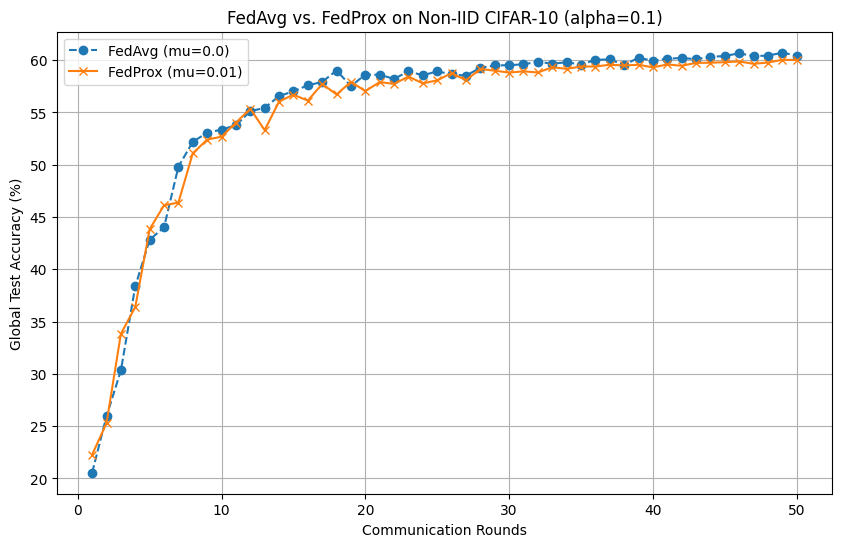

In [8]:
plt.figure(figsize=(10, 6))
rounds = range(1, HYPERPARAMS['num_rounds'] + 1)

# Plot FedAvg
plt.plot(rounds, results['fedavg']['accuracy'], label=f"FedAvg (mu=0.0)", marker='o', linestyle='--')

# Plot FedProx
plt.plot(rounds, results['fedprox']['accuracy'], label=f"FedProx (mu={HYPERPARAMS['mu']})", marker='x', linestyle='-')

plt.title(f"FedAvg vs. FedProx on Non-IID CIFAR-10 (alpha={HYPERPARAMS['dirichlet_alpha']})")
plt.xlabel("Communication Rounds")
plt.ylabel("Global Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


## 9. Observations (for your report)

As required by the prompt, you should now analyze the plot.

* **Does FedProx help?** You will likely observe that the FedProx curve is more stable (less oscillation) and potentially converges to a higher final accuracy than the standard FedAvg baseline. This demonstrates its ability to mitigate the client drift caused by the highly non-IID data.
* **What to report:** You can state your hyperparameters (e.g., `alpha=0.1`, `mu=0.01`, `K=5`) and report the final accuracy numbers. For example: "Under a high-heterogeneity setting (Dirichlet $\alpha=0.1$), FedAvg achieved a final accuracy of X%, while FedProx stabilized training and improved accuracy to Y%".

## 10. Saving models and results

In [9]:
import torch
import json

print("\n--- Saving Final Models and Results ---")

# 1. Save the FedAvg model's weights
torch.save(global_model_fedavg.state_dict(), "fedavg_final_model.pth")
print("Saved FedAvg model state to 'fedavg_final_model.pth'")

# 2. Save the FedProx model's weights
torch.save(global_model_fedprox.state_dict(), "fedprox_final_model.pth")
print("Saved FedProx model state to 'fedprox_final_model.pth'")

# 3. Save the results dictionary as a JSON file
with open("fedavg_vs_fedprox_results.json", 'w') as f:
    json.dump(results, f, indent=4)
print("Saved training results to 'fedavg_vs_fedprox_results.json'")


--- Saving Final Models and Results ---
Saved FedAvg model state to 'fedavg_final_model.pth'
Saved FedProx model state to 'fedprox_final_model.pth'
Saved training results to 'fedavg_vs_fedprox_results.json'
